In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 15.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.preprocessing import image

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_size = (32, 32)


# Reshape the training dataset
train_generator = ImageDataGenerator(rescale=1./255.)
train = train_generator.flow_from_directory(
    '/content/drive/MyDrive/Vision_Transformer/butterly_dataset/train',
    batch_size=32,
    class_mode='categorical',
    target_size=target_size
)

# Reshape the validation dataset
valid_generator = ImageDataGenerator(rescale=1./255.)
valid = valid_generator.flow_from_directory(
    '/content/drive/MyDrive/Vision_Transformer/butterly_dataset/valid',
    batch_size=32,
    class_mode='categorical',
    target_size=target_size
)

# Reshape the test dataset
test_generator = ImageDataGenerator(rescale=1./255.)
test = test_generator.flow_from_directory(
    '/content/drive/MyDrive/Vision_Transformer/butterly_dataset/test',
    batch_size=32,
    class_mode='categorical',
    target_size=target_size
)

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs =100
image_size=32
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 #(for feature vectors)
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8 #8 times
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
#skip connection

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches #define the number of patches
        self.projection = layers.Dense(units=projection_dim) #Add dense layer to projection
        self.position_embedding = layers.Embedding( #Define embedding table
                                                   #takes from index code into position in embedding table and returns the vector
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
input_shape=(32,32,3)
num_classes=100

In [ ]:
#Define the model ViT
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train,
        epochs=num_epochs,
        validation_data=valid,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
394/394 [==============================] - 4410s 11s/step - loss: 4.8061 - accuracy: 0.0094 - top-5-accuracy: 0.0496 - val_loss: 4.6071 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.0500
Epoch 2/100
394/394 [==============================] - 45s 115ms/step - loss: 4.6203 - accuracy: 0.0114 - top-5-accuracy: 0.0510 - val_loss: 4.6077 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.0520
Epoch 3/100
394/394 [==============================] - 46s 116ms/step - loss: 4.6103 - accuracy: 0.0126 - top-5-accuracy: 0.0579 - val_loss: 4.6084 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.0500
Epoch 4/100
394/394 [==============================] - 45s 114ms/step - loss: 4.6102 - accuracy: 0.0141 - top-5-accuracy: 0.0599 - val_loss: 4.6073 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.0500
Epoch 5/100
394/394 [==============================] - 45s 114ms/step - loss: 4.6145 - accuracy: 0.0137 - top-5-accuracy: 0.0599 - val_loss: 4.6077 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.0500


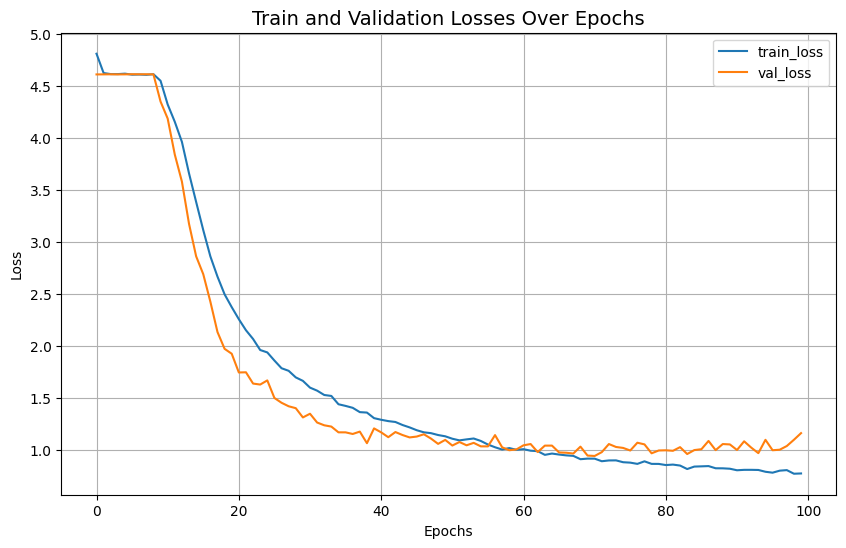

In [ ]:
 # Plotting code
if history is not None:  # Ensure history is not None before accessing it
        plt.figure(figsize=(10,6))  # specify figure size for better visibility
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Train and Validation Losses Over Epochs", fontsize=14)
        plt.legend()
        plt.grid(True)  # to ensure the grid is displayed
        plt.show()
else:
        print("No training history to plot.")